In [1]:
import os, cv2, time
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import albumentations as album

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

from torchvision import transforms

from PIL import Image

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

In [2]:
#with torch.no_grad():
#    torch.cuda.empty_cache()

In [3]:
def create_paths(dataset_dir):
    rgb_files = []
    mask_files = []
    for root, dirs, files in os.walk(dataset_dir):
        for name in files:
            f = os.path.join(root, name)
            if 'labelIds' in f:
                mask_files.append(f)
            elif 'rgb_anon' in f:
                rgb_files.append(f)
            else:
                pass
    return sorted(rgb_files), sorted(mask_files)

In [4]:
class customDataset(Dataset):
    """ Custom Dataset for multiclass semantic segmentation.

    Args:
        df (pd.DataFrame): DataFrame containing paths to images and masks.
        class_list (list): List of class IDs to extract from segmentation mask.
        preprocessing (callable, optional): Data preprocessing function.
    """
    
    def __init__(self, df, class_list=None, augmentation=None, preprocessing=None):
        self.image_paths = df['rgb_file'].tolist()
        self.mask_paths = df['mask_file'].tolist()

        self.class_list = class_list
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        # Original Cityscapes IDs to be mapped to your 6 classes
        # [7, 11, 21, 26, 23, 24] # ['road', 'building', 'vegetation', 'car', 'sky', 'person']
        self.cityscapes_ids = [7, 11, 21, 26, 23]  # Target classes
        # Mapping to new class indices [0, 1, 2, 3, 4, 5]
        self.new_class_mapping = {7: 1, 11: 2, 21: 3, 26: 4, 23: 5}   
        # Define a background class ID
        #self.background_class_id = -1  # Or any other value not used by your classes

    def __getitem__(self, i):
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2GRAY)  # Read mask as grayscale

        # Resize images and masks (640, 480)/(1920, 1080)
        image = cv2.resize(image, (1920, 1056), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (1920, 1056), interpolation=cv2.INTER_NEAREST)

        image = np.asarray(image).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            image = self.preprocessing(image)
            image = torch.as_tensor(image)
        else:
            # Normalize image to [0, 1]
            image = torch.as_tensor(image) / 255.0
        image = image.permute(2,0,1)

        # Convert mask to tensor
        #mask = torch.as_tensor(mask, dtype=torch.uint8)
        
        # Map original Cityscapes IDs to the new class indices
        mask_mapped = np.zeros_like(mask, dtype=np.uint8)  # Initialize new mask
        for original_id, new_id in self.new_class_mapping.items():
            mask_mapped[mask == original_id] = new_id

        # Convert mask to tensor with the mapped classes
        mask_tensor = torch.as_tensor(mask_mapped, dtype=torch.long)

        # -------------------
        # Convert mask to tensor and remap class IDs
        #mask = torch.as_tensor(mask, dtype=torch.uint8)
        #mask_mapped = torch.full_like(mask, self.background_class_id, dtype=torch.long)  # Initialize new mask with background class ID
        
        #for original_id, new_id in self.new_class_mapping.items():
        #    mask_mapped[mask == original_id] = new_id

        return image.float(), mask_tensor

    def __len__(self):
        return len(self.image_paths)


In [5]:
# for ACDC-Night dataset
dataset_acdc_dir = '/home/vhsillerico/Documents/datasets/acdc-night'
imgs_acdc_rgb, imgs_acdc_mask = create_paths(dataset_acdc_dir)
df_acdc = pd.DataFrame({'rgb_file': imgs_acdc_rgb, 'mask_file': imgs_acdc_mask})
df_acdc.sort_values(by='rgb_file',inplace=True)
df_acdc.reset_index(drop=True, inplace=True)
df_acdc = df_acdc.sample(frac=1).reset_index(drop=True)
df_acdc.head(5)

# Split data 85% for trainig and 15% for validation
df_acdc_train, df_acdc_val = train_test_split(df_acdc, test_size=0.15)

df_acdc_train.reset_index(drop=True, inplace=True)
df_acdc_val.reset_index(drop=True, inplace=True)

print(f'acdc-shape = {df_acdc.shape} --- train-shape={df_acdc_train.shape} --- val-shape={df_acdc_val.shape}')

acdc-shape = (506, 2) --- train-shape=(430, 2) --- val-shape=(76, 2)


In [6]:
selected_class_list = [7, 11, 21, 26, 23] # ['road', 'building', 'vegetation', 'car', 'sky', 'person']

In [7]:
#activation = torch.nn.Softmax(dim=1)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

BACKBONE = 'resnext50_32x4d'
#segmodel = smp.Unet(BACKBONE, classes=6, activation='softmax2d').to(device)

#segmodel = smp.Unet(BACKBONE, classes=6, activation=None).to(device)

preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

In [8]:
# image dimensions: (480, 640) (H,W)
global h_aux, w_aux
h_aux = 1056
w_aux = 1920
h_crop_size = 1056
w_crop_size = 1920
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=h_crop_size, width=w_crop_size, always_apply=True),
        album.PadIfNeeded(min_height=480, min_width=640, always_apply=True, border_mode=0, value=(0, 0, 0)),
        album.HorizontalFlip(p=0.75),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        #album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0, value=(0, 0, 0)),
        album.PadIfNeeded(min_height=h_aux, min_width=w_aux, always_apply=True, border_mode=0, value=(0, 0, 0)),
    ]
    return album.Compose(test_transform)

In [9]:
# configure dataset for training
train_data = customDataset(df_acdc_train, class_list=selected_class_list, preprocessing=preprocess_input)
img_train, masks_train = train_data[1]
print(img_train.shape, masks_train.shape)

torch.Size([3, 1056, 1920]) torch.Size([1056, 1920])


In [10]:
np.unique(masks_train.detach().cpu().numpy())

array([0, 1, 2, 3, 4, 5])

In [11]:
#def visualize(**images):
#    """
#    Plot images in one row
#    """
#    n_images = len(images)
#    plt.figure(figsize=(20,8))
#    for idx, (name, image) in enumerate(images.items()):
#        plt.subplot(1, n_images, idx + 1)
#        plt.xticks([]);
#        plt.yticks([])
#        # get title from the parameter names
#        plt.title(name.replace('_',' ').title(), fontsize=20)
#        plt.imshow(image)
#    plt.show()

In [12]:
# configure dataset for training
val_data = customDataset(df_acdc_val, class_list=selected_class_list, preprocessing=preprocess_input)
img_val, masks_val = val_data[0]
print(img_val.shape, masks_val.shape)

torch.Size([3, 1056, 1920]) torch.Size([1056, 1920])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


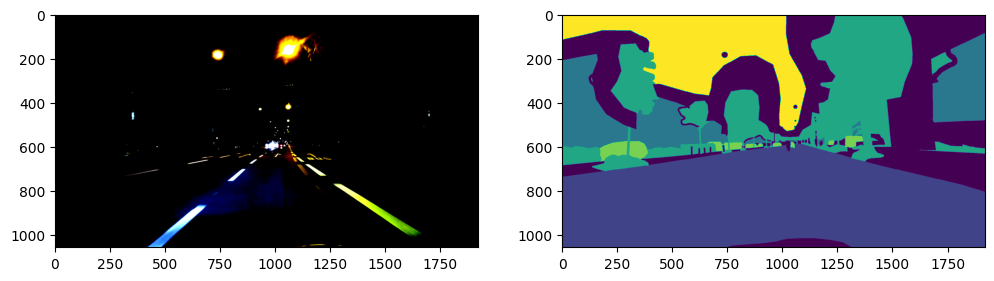

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(img_train.permute(1, 2, 0))
ax[1].imshow(masks_train) # ['road', 'building', 'vegetation', 'car', 'sky', 'person']
plt.show()

In [14]:
train_data_loader = DataLoader(
    train_data,
    batch_size=4,
    shuffle=True
)
val_data_loader = DataLoader(
    val_data,
    batch_size=2,
    shuffle=False
)

In [15]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    break

torch.Size([4, 3, 1056, 1920]) torch.Size([4, 1056, 1920])
tensor(-2.1179) tensor(2.6400)
tensor(0) tensor(5)


In [16]:
# COMPLETE FINAL VERSION ************************************

# Function to compute IoU per class
def compute_iou(pred, target, num_classes):
    iou_list = []
    for cls in range(num_classes):
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        
        intersection = torch.sum(pred_cls * target_cls)
        union = torch.sum(pred_cls) + torch.sum(target_cls) - intersection
        
        iou = intersection / (union + 1e-7)  # Adding epsilon to avoid division by zero
        iou_list.append(iou.item())
    
    return iou_list

# Function to compute F1-score per class
def compute_f1_score(pred, target, num_classes):
    f1_scores = []
    for cls in range(num_classes):
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        
        intersection = torch.sum(pred_cls * target_cls)
        precision = intersection / (torch.sum(pred_cls) + 1e-7)
        recall = intersection / (torch.sum(target_cls) + 1e-7)
        
        f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
        f1_scores.append(f1.item())
    
    return f1_scores

# Initialize DataFrame to store logs
logs_df = pd.DataFrame(columns=[
    'Epoch', 'Train_Loss', 'Train_IoU_per_Class', 'Train_Mean_IoU',
    'Train_F1_per_Class', 'Train_Mean_F1',
    'Val_Loss', 'Val_IoU_per_Class', 'Val_Mean_IoU',
    'Val_F1_per_Class', 'Val_Mean_F1'
])

num_classes = 6
num_epochs = 30  # Adjust as needed


# Define your model, loss function, and optimizer
segmodel = smp.PSPNet(encoder_name='resnext50_32x4d', encoder_weights='imagenet', classes=num_classes, activation=None).to(device)
# Define your model with dropout
#segmodel = smp.Unet(BACKBONE, classes=num_classes, activation=None, encoder_weights=None, dropout=dropout_rate).to(device)

criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(segmodel.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = torch.optim.Adam(segmodel.parameters(), lr=0.001)

# Initialize DataFrame to store logs
logs_df = pd.DataFrame(columns=['Epoch',
                                'Train_Loss',
                                'Train_IoU_per_Class',
                                'Train_Mean_IoU',
                                'Train_F1_per_Class',
                                'Train_Mean_F1',
                                'Val_Loss',
                                'Val_IoU_per_Class',
                                'Val_Mean_IoU',
                                'Val_F1_per_Class',
                                'Val_Mean_F1'])
# Train model
max_score = 0

# Training and validation loop
for epoch in range(num_epochs):
    start_time = time.time()  # Track start time
    # Training
    segmodel.train()
    train_loss = 0
    train_iou_scores = []
    train_f1_scores = []
    
    # Progress bar for training
    with tqdm(total=len(train_data_loader), desc=f'Epoch {epoch + 1}/{num_epochs} - Training', unit='batch') as pbar:
        for batch in train_data_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            pred = segmodel(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Calculate IoU and F1-score
            pred_classes = torch.argmax(pred, dim=1)
            iou = compute_iou(pred_classes, y, num_classes)
            f1_score = compute_f1_score(pred_classes, y, num_classes)
            
            train_iou_scores.append(iou)
            train_f1_scores.append(f1_score)
            
            pbar.set_postfix({'Train_Loss': loss.item(), 'IoU': np.mean(iou), 'F1': np.mean(f1_score)})
            pbar.update(1)
    
    # Calculate mean metrics for training
    avg_train_iou = np.mean(train_iou_scores, axis=0)
    mean_train_iou = np.mean(avg_train_iou)
    avg_train_f1 = np.mean(train_f1_scores, axis=0)
    mean_train_f1 = np.mean(avg_train_f1)
    avg_train_loss = train_loss / len(train_data_loader)
    
    # Validation
    segmodel.eval()
    val_loss = 0
    val_iou_scores = []
    val_f1_scores = []
    
    with torch.no_grad():
        # Progress bar for validation
        with tqdm(total=len(val_data_loader), desc=f'Epoch {epoch + 1}/{num_epochs} - Validation', unit='batch') as pbar:
            for batch in val_data_loader:
                x, y = batch
                x, y = x.to(device), y.to(device)
                pred = segmodel(x)
                
                loss = criterion(pred, y)
                val_loss += loss.item()
                
                # Calculate IoU and F1-score
                pred_classes = torch.argmax(pred, dim=1)
                iou = compute_iou(pred_classes, y, num_classes)
                f1_score = compute_f1_score(pred_classes, y, num_classes)
                
                val_iou_scores.append(iou)
                val_f1_scores.append(f1_score)
                
                pbar.set_postfix({'Val_Loss': loss.item(), 'IoU': np.mean(iou), 'F1': np.mean(f1_score)})
                pbar.update(1)
    
    # Calculate mean metrics for validation
    avg_val_iou = np.mean(val_iou_scores, axis=0)
    mean_val_iou = np.mean(avg_val_iou)
    avg_val_f1 = np.mean(val_f1_scores, axis=0)
    mean_val_f1 = np.mean(avg_val_f1)
    avg_val_loss = val_loss / len(val_data_loader)
    
    # Save logs to DataFrame
    new_log = {
        'Epoch': epoch + 1,
        'Train_Loss': avg_train_loss,
        'Train_IoU_per_Class': avg_train_iou,
        'Train_Mean_IoU': mean_train_iou,
        'Train_F1_per_Class': avg_train_f1,
        'Train_Mean_F1': mean_train_f1,
        'Val_Loss': avg_val_loss,
        'Val_IoU_per_Class': avg_val_iou,
        'Val_Mean_IoU': mean_val_iou,
        'Val_F1_per_Class': avg_val_f1,
        'Val_Mean_F1': mean_val_f1
    }
    # Convert the new_row dictionary to a DataFrame
    new_log_df = pd.DataFrame([new_log])
    # Concatenate the new_row_df to logs_df
    logs_df = pd.concat([logs_df, new_log_df], ignore_index=True)
    
    # Print metrics
    print(f"Epoch {epoch + 1}/{num_epochs} - "
          f"Mean Train IoU: {mean_train_iou:.4f}, "
          f"Mean Train F1-score: {mean_train_f1:.4f}, "
          f"Avg Train Loss: {avg_train_loss:.4f}, "
          f"Mean Val IoU: {mean_val_iou:.4f}, "
          f"Mean Val F1-score: {mean_val_f1:.4f}, "
          f"Avg Val Loss: {avg_val_loss:.4f}")

    # Calculate and print time for each epoch
    epoch_time = time.time() - start_time
    print(f"Time: {epoch_time:.2f} seconds")

    # Save the model if it's the best one
    if mean_val_iou > max_score:
        max_score = mean_val_iou
        torch.save(segmodel.state_dict(), './acdc_best_model_pspnet_multiclass_merged30e.pth')
        print('Model saved!')

total_time = epoch_time * num_epochs
print(f"Estimated total training time: {total_time/60:.2f} minutes")
# Save DataFrame to CSV
logs_df.to_csv('acdc_best_model_pspnet_multiclass_merged30e.csv', index=False)


Epoch 1/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 1/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 1/30 - Mean Train IoU: 0.3995, Mean Train F1-score: 0.5281, Avg Train Loss: 0.9459, Mean Val IoU: 0.4223, Mean Val F1-score: 0.5393, Avg Val Loss: 0.7933
Time: 125.46 seconds
Model saved!


Epoch 2/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 2/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 2/30 - Mean Train IoU: 0.4870, Mean Train F1-score: 0.6247, Avg Train Loss: 0.7331, Mean Val IoU: 0.4333, Mean Val F1-score: 0.5512, Avg Val Loss: 0.8341
Time: 130.53 seconds
Model saved!


Epoch 3/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 3/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 3/30 - Mean Train IoU: 0.5264, Mean Train F1-score: 0.6627, Avg Train Loss: 0.6662, Mean Val IoU: 0.4466, Mean Val F1-score: 0.5685, Avg Val Loss: 0.7721
Time: 128.05 seconds
Model saved!


Epoch 4/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 4/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 4/30 - Mean Train IoU: 0.5634, Mean Train F1-score: 0.6986, Avg Train Loss: 0.6007, Mean Val IoU: 0.5336, Mean Val F1-score: 0.6591, Avg Val Loss: 0.6178
Time: 126.32 seconds
Model saved!


Epoch 5/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 5/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 5/30 - Mean Train IoU: 0.5841, Mean Train F1-score: 0.7173, Avg Train Loss: 0.5620, Mean Val IoU: 0.4715, Mean Val F1-score: 0.5886, Avg Val Loss: 0.7560
Time: 126.86 seconds


Epoch 6/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 6/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 6/30 - Mean Train IoU: 0.5926, Mean Train F1-score: 0.7235, Avg Train Loss: 0.5411, Mean Val IoU: 0.5103, Mean Val F1-score: 0.6382, Avg Val Loss: 0.6950
Time: 125.88 seconds


Epoch 7/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 7/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 7/30 - Mean Train IoU: 0.5919, Mean Train F1-score: 0.7212, Avg Train Loss: 0.5392, Mean Val IoU: 0.5114, Mean Val F1-score: 0.6287, Avg Val Loss: 0.6065
Time: 126.54 seconds


Epoch 8/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 8/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 8/30 - Mean Train IoU: 0.6108, Mean Train F1-score: 0.7391, Avg Train Loss: 0.5138, Mean Val IoU: 0.5137, Mean Val F1-score: 0.6366, Avg Val Loss: 0.7159
Time: 124.57 seconds


Epoch 9/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 9/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 9/30 - Mean Train IoU: 0.6165, Mean Train F1-score: 0.7442, Avg Train Loss: 0.5073, Mean Val IoU: 0.5010, Mean Val F1-score: 0.6203, Avg Val Loss: 0.6789
Time: 124.51 seconds


Epoch 10/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 10/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 10/30 - Mean Train IoU: 0.6309, Mean Train F1-score: 0.7565, Avg Train Loss: 0.4872, Mean Val IoU: 0.5577, Mean Val F1-score: 0.6721, Avg Val Loss: 0.5376
Time: 128.46 seconds
Model saved!


Epoch 11/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 11/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 11/30 - Mean Train IoU: 0.6350, Mean Train F1-score: 0.7595, Avg Train Loss: 0.4732, Mean Val IoU: 0.5894, Mean Val F1-score: 0.7118, Avg Val Loss: 0.5331
Time: 126.63 seconds
Model saved!


Epoch 12/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 12/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 12/30 - Mean Train IoU: 0.6560, Mean Train F1-score: 0.7759, Avg Train Loss: 0.4411, Mean Val IoU: 0.5785, Mean Val F1-score: 0.6990, Avg Val Loss: 0.5406
Time: 120.55 seconds


Epoch 13/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 13/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 13/30 - Mean Train IoU: 0.6545, Mean Train F1-score: 0.7768, Avg Train Loss: 0.4491, Mean Val IoU: 0.5988, Mean Val F1-score: 0.7214, Avg Val Loss: 0.5246
Time: 121.28 seconds
Model saved!


Epoch 14/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 14/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 14/30 - Mean Train IoU: 0.6686, Mean Train F1-score: 0.7867, Avg Train Loss: 0.4239, Mean Val IoU: 0.5526, Mean Val F1-score: 0.6740, Avg Val Loss: 0.5829
Time: 120.57 seconds


Epoch 15/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 15/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 15/30 - Mean Train IoU: 0.6677, Mean Train F1-score: 0.7864, Avg Train Loss: 0.4222, Mean Val IoU: 0.5739, Mean Val F1-score: 0.6946, Avg Val Loss: 0.5533
Time: 129.33 seconds


Epoch 16/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 16/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 16/30 - Mean Train IoU: 0.6790, Mean Train F1-score: 0.7952, Avg Train Loss: 0.4079, Mean Val IoU: 0.5284, Mean Val F1-score: 0.6458, Avg Val Loss: 0.6549
Time: 127.87 seconds


Epoch 17/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 17/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 17/30 - Mean Train IoU: 0.6741, Mean Train F1-score: 0.7911, Avg Train Loss: 0.4137, Mean Val IoU: 0.5675, Mean Val F1-score: 0.6923, Avg Val Loss: 0.5704
Time: 128.98 seconds


Epoch 18/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 18/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 18/30 - Mean Train IoU: 0.6823, Mean Train F1-score: 0.7971, Avg Train Loss: 0.3936, Mean Val IoU: 0.6032, Mean Val F1-score: 0.7268, Avg Val Loss: 0.5261
Time: 129.73 seconds
Model saved!


Epoch 19/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 19/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 19/30 - Mean Train IoU: 0.6933, Mean Train F1-score: 0.8059, Avg Train Loss: 0.3799, Mean Val IoU: 0.5862, Mean Val F1-score: 0.7085, Avg Val Loss: 0.5750
Time: 128.62 seconds


Epoch 20/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 20/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 20/30 - Mean Train IoU: 0.6982, Mean Train F1-score: 0.8104, Avg Train Loss: 0.3797, Mean Val IoU: 0.5861, Mean Val F1-score: 0.7121, Avg Val Loss: 0.5932
Time: 126.86 seconds


Epoch 21/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 21/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 21/30 - Mean Train IoU: 0.7021, Mean Train F1-score: 0.8136, Avg Train Loss: 0.3744, Mean Val IoU: 0.5847, Mean Val F1-score: 0.7078, Avg Val Loss: 0.5817
Time: 127.34 seconds


Epoch 22/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 22/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 22/30 - Mean Train IoU: 0.7024, Mean Train F1-score: 0.8132, Avg Train Loss: 0.3654, Mean Val IoU: 0.6028, Mean Val F1-score: 0.7260, Avg Val Loss: 0.5423
Time: 127.86 seconds


Epoch 23/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 23/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 23/30 - Mean Train IoU: 0.7236, Mean Train F1-score: 0.8288, Avg Train Loss: 0.3407, Mean Val IoU: 0.5629, Mean Val F1-score: 0.6793, Avg Val Loss: 0.5881
Time: 127.07 seconds


Epoch 24/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 24/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 24/30 - Mean Train IoU: 0.7137, Mean Train F1-score: 0.8214, Avg Train Loss: 0.3509, Mean Val IoU: 0.5990, Mean Val F1-score: 0.7214, Avg Val Loss: 0.5656
Time: 124.94 seconds


Epoch 25/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 25/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 25/30 - Mean Train IoU: 0.7192, Mean Train F1-score: 0.8256, Avg Train Loss: 0.3411, Mean Val IoU: 0.5487, Mean Val F1-score: 0.6678, Avg Val Loss: 0.6559
Time: 125.64 seconds


Epoch 26/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 26/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 26/30 - Mean Train IoU: 0.7321, Mean Train F1-score: 0.8361, Avg Train Loss: 0.3261, Mean Val IoU: 0.5864, Mean Val F1-score: 0.7114, Avg Val Loss: 0.6258
Time: 125.98 seconds


Epoch 27/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 27/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 27/30 - Mean Train IoU: 0.7334, Mean Train F1-score: 0.8371, Avg Train Loss: 0.3237, Mean Val IoU: 0.6181, Mean Val F1-score: 0.7383, Avg Val Loss: 0.5134
Time: 126.40 seconds
Model saved!


Epoch 28/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 28/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 28/30 - Mean Train IoU: 0.7330, Mean Train F1-score: 0.8370, Avg Train Loss: 0.3236, Mean Val IoU: 0.6102, Mean Val F1-score: 0.7302, Avg Val Loss: 0.5732
Time: 126.23 seconds


Epoch 29/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 29/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 29/30 - Mean Train IoU: 0.7244, Mean Train F1-score: 0.8300, Avg Train Loss: 0.3326, Mean Val IoU: 0.6287, Mean Val F1-score: 0.7478, Avg Val Loss: 0.5031
Time: 127.01 seconds
Model saved!


Epoch 30/30 - Training:   0%|          | 0/108 [00:00<?, ?batch/s]

Epoch 30/30 - Validation:   0%|          | 0/38 [00:00<?, ?batch/s]

Epoch 30/30 - Mean Train IoU: 0.7422, Mean Train F1-score: 0.8423, Avg Train Loss: 0.3132, Mean Val IoU: 0.6092, Mean Val F1-score: 0.7313, Avg Val Loss: 0.5932
Time: 125.38 seconds
Estimated total training time: 62.69 minutes


In [17]:
# load best saved model checkpoint from the current run
if os.path.exists('./acdc_best_model_pspnet_multiclass_merged30e.pth'):
    best_model = torch.load('./acdc_best_model_pspnet_multiclass_merged30e.pth', map_location=device)
    print('Loaded PSPNet model from this run.')
else:
    print("There is not a saved model")

Loaded PSPNet model from this run.


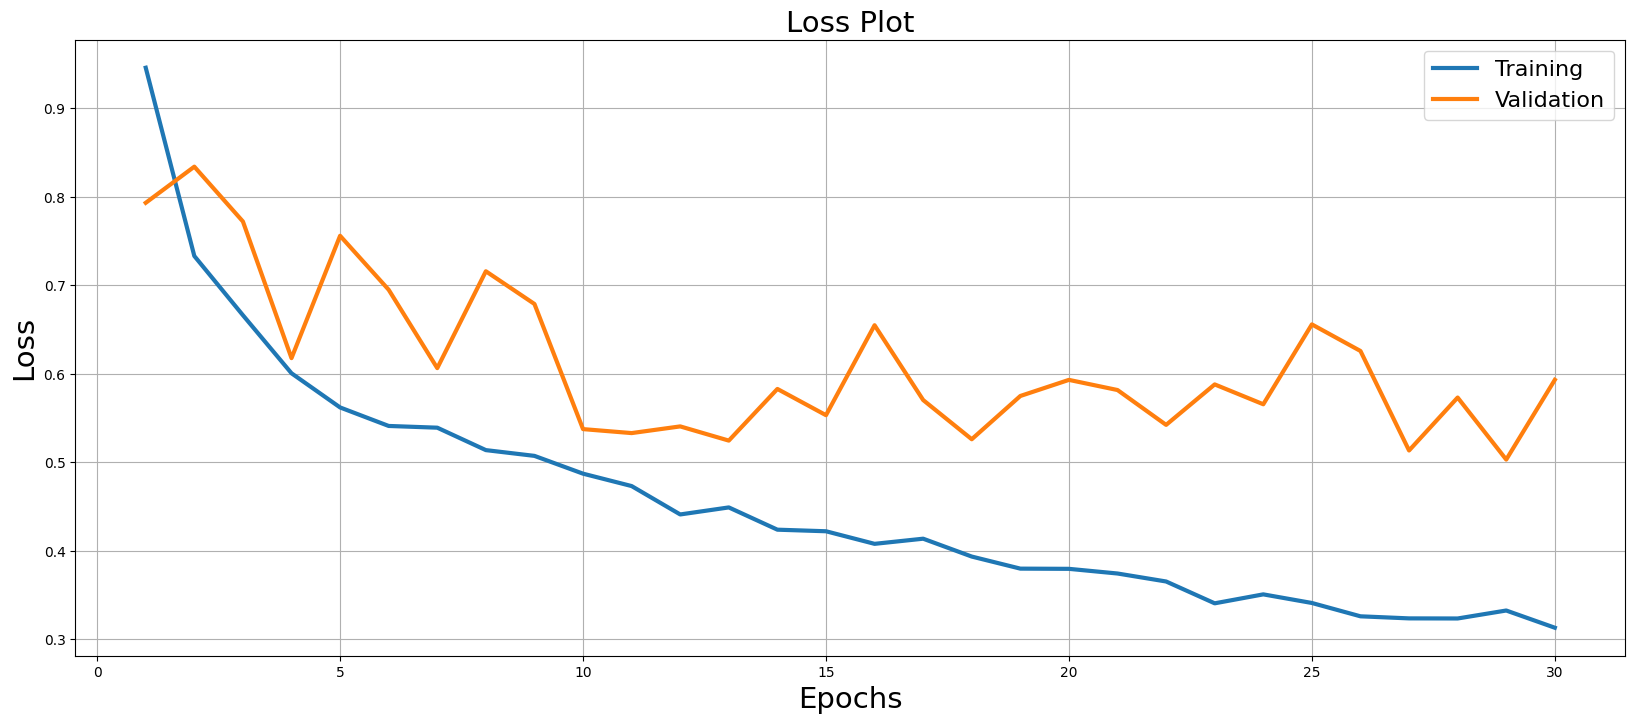

In [18]:
plt.figure(figsize=(20,8))
plt.plot(logs_df.Epoch.tolist(), logs_df.Train_Loss.tolist(), lw=3, label = 'Training')
plt.plot(logs_df.Epoch.tolist(), logs_df.Val_Loss.tolist(), lw=3, label = 'Validation')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Loss', fontsize=21)
plt.title('Loss Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('Loss-pspnet.png')
plt.show()